In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md


#Function for importing site CSV files as pandas dataframes
def import_site_data(file):
    #Read in CSV file, skipping the first 4 rows and making any "No data" values NaN
    df = pd.read_csv(file, skiprows=4, na_values="No data")
    #Convert the "Date Time" column from strings to DateTime objects
    df["Date Time"] = pd.to_datetime(df["Date Time"])
    #Make the dataframe indexed by date for ease of use later
    df = df.set_index("Date Time")

    return df


#Variables for file paths to site CSV files
urban_file = "data/Marylebone_AirQualityDataHourly_2018-2021_clean.csv"
rural_file = "data/Rochester_AirQualityDataHourly_2018-2021_clean.csv"


#Storing column names of PM concentration for ease of use and readability
PM10_key = "PM10 particulate matter (Hourly measured)"
PM25_key = "PM2.5 particulate matter (Hourly measured)"

#Import both site CSV files as pandas dataframes
urban_df = import_site_data(urban_file)
rural_df = import_site_data(rural_file)

In [57]:

#Get the first and last date recorded in the urban dataframe
start_date = urban_df.index[0]
end_date = urban_df.index[-1]

#Create series of dates, each month from the specified start to end date
month_range = pd.date_range(start=start_date, end=end_date, freq="ME")

#Create lists to hold the concentrations of average PM10 per month
urban_PM10_months = []
rural_PM10_months = []

#Loop through every month in the series
for date in month_range:
    #Create string containing the year and month pulled from the date object in the format - "YYYY-MM"
    date_string = "%s-%s" % (date.year, date.month)
    #Select all PM10 concentration recordings for the month and calculate their mean. Append this to the list
    urban_PM10_months.append(urban_df.loc[date_string][PM10_key].mean())
    rural_PM10_months.append(rural_df.loc[date_string][PM10_key].mean())


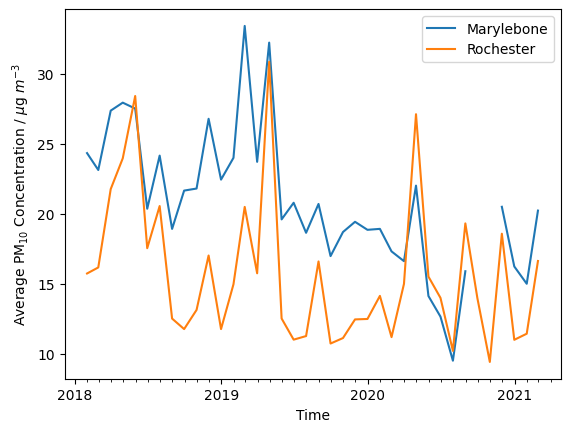

In [58]:
fig, ax_avg = plt.subplots()

#Plot line graph of the average concentration of PM10 per month against the series of dates for both sites
ax_avg.plot(month_range, urban_PM10_months, label="Marylebone")
ax_avg.plot(month_range, rural_PM10_months, label="Rochester")

#Format x axis to show each year rather than all dates
ax_avg.xaxis.set_major_formatter(md.DateFormatter("%Y"))
ax_avg.xaxis.set_major_locator(md.YearLocator())
#Format x axis to show small ticks for every month
ax_avg.xaxis.set_minor_locator(md.MonthLocator())

#Set x axis title
ax_avg.set_xlabel("Time")

#Set y axis title - this line contains formatting for subscript/superscipt and greek letters
ax_avg.set_ylabel(r"Average PM$_{10}$ Concentration / $\mu$g $m^{-3}$")

ax_avg.legend()

plt.savefig("Marylebone_vs_Rochester_PM10")

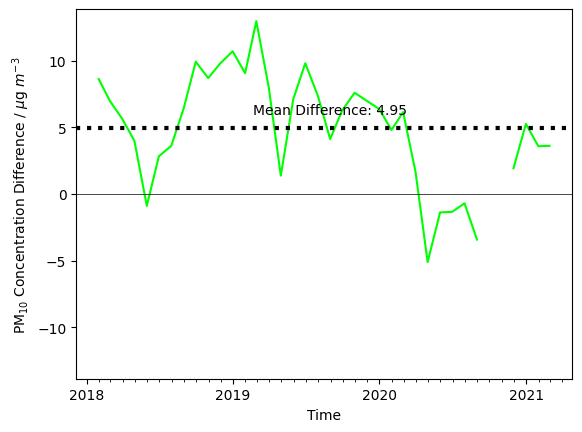

In [59]:
fig, ax_dif = plt.subplots()

#Calculate difference in average PM10 concentration between urban and rural areas. Both lists must be converted to numpy arrays before subtraction
difference_PM10 = np.array(urban_PM10_months)-np.array(rural_PM10_months)

#Plot line graph of difference in PM10 concentration against time
ax_dif.plot(month_range, difference_PM10, color="lime")

#Find the absolute largest y value
y_max = abs(max(ax_dif.get_ylim(), key=abs))
#Set the limits of the y axis to be the absolute maximum y values so that the graph is centred on 0
ax_dif.set_ylim(ymin=-y_max, ymax=y_max)
#Draw line at 0 for new x axis
ax_dif.axhline(y=0, c="black", lw=0.5)

#Format x axis to show each year rather than all dates
ax_dif.xaxis.set_major_formatter(md.DateFormatter("%Y"))
ax_dif.xaxis.set_major_locator(md.YearLocator())

#Format x axis to show small ticks for every month
ax_dif.xaxis.set_minor_locator(md.MonthLocator())

#Set y axis title - this line contains formatting for subscript/superscipt and greek letters
ax_dif.set_ylabel(r"PM$_{10}$ Concentration Difference / $\mu$g $m^{-3}$")

#Set x axis title
ax_dif.set_xlabel("Time")

#Calculate mean of differences in PM10 concentration. All NaN values must first be removed before mean is taken
average_difference_PM10 = difference_PM10[np.isfinite(difference_PM10)].mean()

#Draw dotted black line to represent the average difference in PM10 concentration
ax_dif.axhline(y=average_difference_PM10, color="black", lw=3, ls="dotted")

#Round averge to 2 decimal places
label_mean = np.round(average_difference_PM10, 2)
#Set position of label to be the date in the middle of the range and one unit above the lines y coordinate
label_position = (month_range[round(len(month_range)/2)], average_difference_PM10+1)

# Add label for the average difference in PM10 concentration
ax_dif.annotate("Mean Difference: %s" % label_mean, xy=label_position, bbox=dict(facecolor='none', edgecolor='none'), ha="center")

plt.savefig("Marylebone_vs_Rochester__AvgDif_PM10")


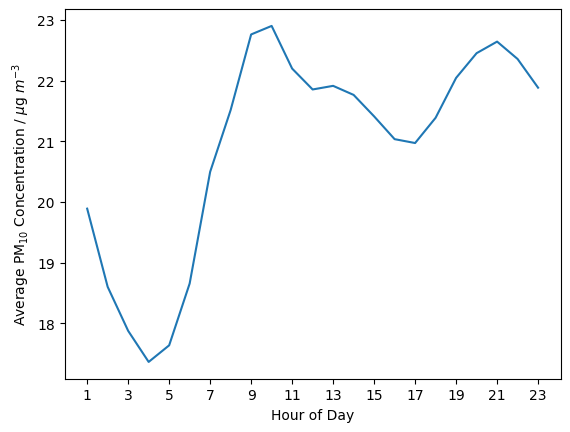

In [65]:
#Create list to hold hourly averages for PM10 concnetration
hourly_PM10_averages = []

#Loop through all hours in day
for hour in range(1, 24):
    #Calculate mean PM10 concentration for every hour in the urban dataset
    hourly_PM10_averages.append(urban_df[urban_df["Hour of Day"] == hour][PM10_key].mean())

fig, ax = plt.subplots()

#Plot hourly PM10 averages
ax.plot(range(1, 24), hourly_PM10_averages)

#Label axes
ax.set_xlabel("Hour of Day")
ax.set_ylabel(r"Average PM$_{10}$ Concentration / $\mu$g $m^{-3}$")
#Change frequency of x labels
ax.set_xticks(np.arange(1, 24, 2))

plt.savefig("Hourly_PM10")

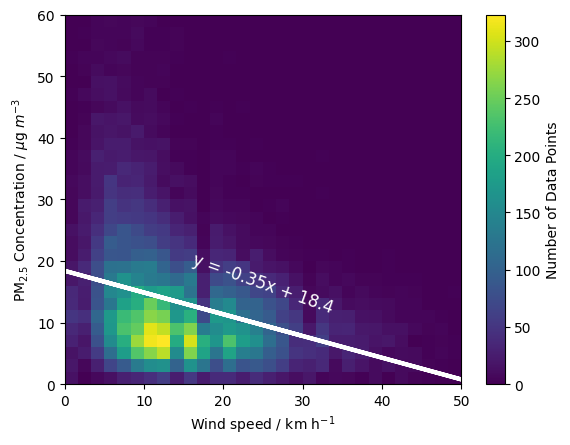

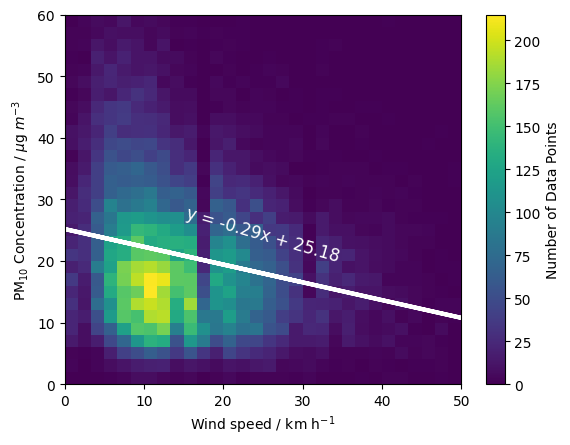

In [61]:
#Variable for file path to site CSV file
weather_file = "data/Weather_data_hourly_Heathrow-Airport.csv"

#Import CSV weather file as pandas dataframe
weather_df = pd.read_csv(weather_file)
#Rename the "Date_Hour" column to "Date Time" to remain consistent with previous dataframes
weather_df = weather_df.rename(columns={"Date_Hour": "Date Time"})
#Convert the "Date Time" column from strings to DateTime objects
weather_df["Date Time"] = pd.to_datetime(weather_df["Date Time"])
#Make the dataframe indexed by date for ease of use later
weather_df = weather_df.set_index("Date Time")

#Create new weather dataframe with the same time frame as the urban dataframe
weather_df_adjusted = weather_df.loc[urban_df.index[0]:urban_df.index[-1]]

#Function for plotting any PM concentration data against windspeed, also takes a label argument which is used for the y axis title
def plot_wind_speed(pm_data, label):

    #Select wind speed column from weather dataframe
    wind_speed = weather_df_adjusted["Wind speed (km/h)"]

    #Create mask which will be used to skip rows in which either the wind speed or the PM concentration is NaN
    fit_mask = np.isfinite(wind_speed) & np.isfinite(pm_data)

    #Apply mask to both sets of data
    masked_wind_speed = wind_speed[fit_mask]
    masked_pm_data = pm_data[fit_mask]

    fig, ax = plt.subplots()

    #Plot a 2D histogram of PM concentration against wind speed
    hist = ax.hist2d(masked_wind_speed, masked_pm_data, bins=30, range=[[0, 50], [0, 60]])

    #Add a bar that shows the correletion between bin colour and the number of points
    fig.colorbar(hist[3], label="Number of Data Points")
    #Set x axis title - this line contains formatting for superscript characters
    ax.set_xlabel(r"Wind speed / km h$^{-1}$")
    #Set y axis title to whatever was passed into the function
    ax.set_ylabel(label)

    #Create a linear line fo best fit for the data using numpy
    fit = np.polyfit(masked_wind_speed, masked_pm_data, 1)

    #Plot a linear line of best fit based on the fit calculated by numpy on top of the 2D histogram
    ax.plot(masked_wind_speed, np.polyval(fit, masked_wind_speed), color="white", lw=3)

    #Add a label for the trend line including equation from fit calculation
    ax.annotate("y = %sx + %s" % (np.round(fit[0], 2), np.round(fit[1], 2)), xy=(25, np.polyval(fit, 25)+2), ha="center", color="white", rotation=np.degrees(np.arctan(fit[0])), fontsize=12)

#Plot graph for PM2.5
plot_wind_speed(urban_df[PM25_key], r"PM$_{2.5}$ Concentration / $\mu$g $m^{-3}$")

plt.savefig("PM25_vs_WindSpeed")

#Plot graph for PM10
plot_wind_speed(urban_df[PM10_key], r"PM$_{10}$ Concentration / $\mu$g $m^{-3}$")

plt.savefig("PM10_vs_WindSpeed")
